## Se importan librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [2]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [3]:
from pyspark.ml.feature import Word2Vec

## Se crea el contexto y la sesion de spark

In [4]:
conf = SparkConf().set("spark.ui.port", "4050")

# creamos el contexto y la sesión
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/01 02:19:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Se leen los datos

In [5]:
data_covid = spark.read.csv('./data/covid_articles_raw.csv', header=True, multiLine=True, escape='"')
data_covid.show()

+--------------------+--------------------+--------+
|               title|             content|category|
+--------------------+--------------------+--------+
|Looking into the ...|Hi, what are you ...| general|
|Hexo refiles fina...|New York reported...| general|
|Japan raid, Turke...|Hi, what are you ...| general|
|Pope's bodyguards...|Hi, what are you ...| general|
|Lebanon denies pr...|Hi, what are you ...| general|
|Lebanese lawyers ...|Hi, what are you ...| general|
|' I did it alone ...|Hi, what are you ...| general|
|Ghosn escape spar...|Hi, what are you ...| general|
|Mexico's Santiago...|Hi, what are you ...| general|
|Fired British veg...|Hi, what are you ...| general|
|US places ban on ...|Hi, what are you ...| general|
|Medicinal cannabi...|Hi, what are you ...| general|
|2020 trends to wa...|Or wait...\nSearc...| general|
|Madonna rings in ...|Hi, what are you ...| general|
|Three Industrial ...|\nWith the end of...|business|
|My experience of ...|“ Helen, I’ m so ...|   

## Se selecciona la columna title

In [6]:
title = data_covid.select('title')

# **Se toma una muestra de 10%** de la data para TEST y se toma una semilla de 3

In [7]:
sample_title = title.sample(fraction = .1, seed = 3)

## Se hace un Split de la columna title y se pone todo el texto en minusculas para TEST

In [8]:
titles = sample_title.withColumn('title_splitted',split(lower(col('title'))," "))

In [9]:
titles.take(2)

[Row(title='An elegy for cash: the technology we might never replace', title_splitted=['an', 'elegy', 'for', 'cash:', 'the', 'technology', 'we', 'might', 'never', 'replace']),
 Row(title='POSTPONED - SpaMedica CET Event – Cataract & AMD Training', title_splitted=['postponed', '-', 'spamedica', 'cet', 'event', '–', 'cataract', '&', 'amd', 'training'])]

## Se aplica el metodo de word2vec con un tamaño de vector 100 , con una minima frecuencia por palabra de 0, 100 iteraciones maximo para TEST

In [10]:
w2v = Word2Vec(vectorSize = 100, minCount = 0, maxIter = 10, inputCol = 'title_splitted', outputCol = 'features')

## Se entrena los datos TEST el modelo con titles

In [11]:
model = w2v.fit(titles)

22/11/01 02:20:23 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/11/01 02:20:23 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


## Se generan los emmbedings de los titulos con el metodo transform para TEST

In [12]:
result =model.transform(titles)

In [13]:
result.take(3)

[Row(title='An elegy for cash: the technology we might never replace', title_splitted=['an', 'elegy', 'for', 'cash:', 'the', 'technology', 'we', 'might', 'never', 'replace'], features=DenseVector([-0.0848, 0.0771, -0.0307, -0.2739, -0.009, 0.0027, 0.0835, -0.2482, 0.033, -0.2011, 0.1535, -0.0521, -0.0645, 0.0235, -0.1801, -0.0847, 0.1449, -0.073, 0.0267, 0.0272, -0.0035, -0.1427, -0.1003, -0.065, -0.1803, 0.033, 0.0056, -0.08, -0.035, 0.1067, -0.1538, 0.0025, -0.1133, 0.0087, -0.1548, -0.177, 0.0456, -0.0797, 0.1744, -0.0469, 0.0373, 0.0316, -0.074, 0.0684, 0.0679, -0.1446, -0.0564, -0.0215, -0.0662, -0.0863, -0.0594, -0.104, 0.1364, 0.2397, -0.1753, -0.026, 0.1137, -0.1784, -0.0129, 0.086, -0.009, 0.0408, 0.0727, 0.0912, -0.2597, -0.032, -0.144, 0.0804, -0.1145, -0.1634, -0.0207, 0.228, -0.0423, -0.0717, 0.2509, 0.0101, 0.028, -0.1158, -0.0143, -0.0354, -0.059, -0.162, 0.11, 0.1932, -0.0569, 0.037, -0.1561, -0.1513, 0.1235, 0.0369, -0.0443, 0.0248, 0.0512, -0.0302, 0.0447, -0.0381, 0.

In [14]:
type(result)


pyspark.sql.dataframe.DataFrame

In [15]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_scores=[]

#assemble=VectorAssembler(inputCols=['title_splitted'],outputCol = 'features')

evaluator = ClusteringEvaluator(featuresCol='features', \
metricName='silhouette', distanceMeasure='squaredEuclidean')

for K in range(2,11):

    KMeans_=KMeans(featuresCol='features', k=K)

    KMeans_fit=KMeans_.fit(result)

    KMeans_transform=KMeans_fit.transform(result) 

    evaluation_score=evaluator.evaluate(KMeans_transform)

    silhouette_scores.append(evaluation_score)

Text(0, 0.5, 'Silhouette Score')

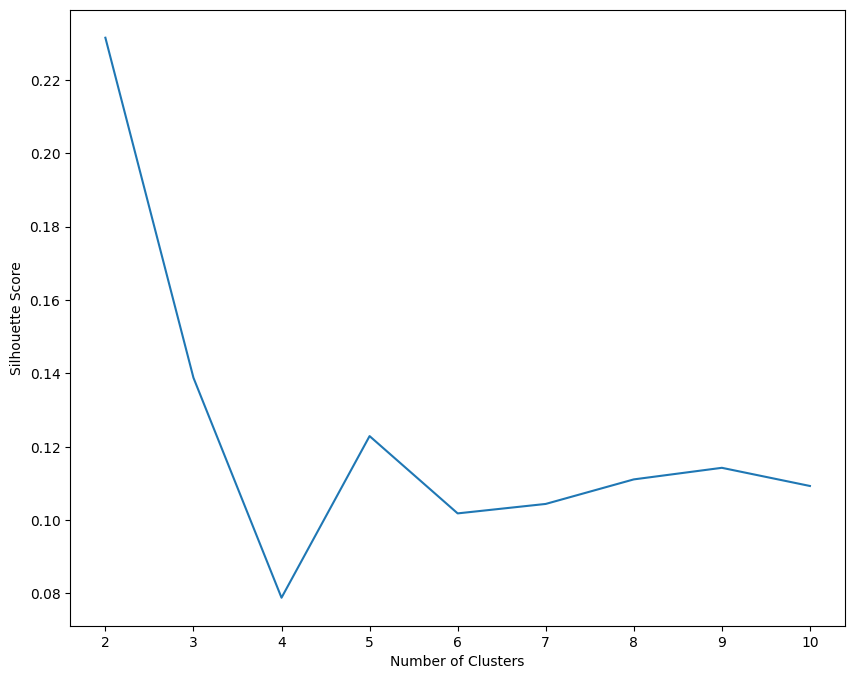

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

## Se entrena un modelo TEST usando kmeans para 100 iteraciones y 3 cluster

In [ ]:
kmeans = KMeans().setMaxIter(100).setK(3).setSeed(1)
kmeans_model = kmeans.fit(result)

## Se hace la predicción de las categorias del modelo TEST

In [ ]:
predictions = kmeans_model.transform(result)
predictions.show()

# Ahora ejecutamos el modelo para todos los datos TRAIN

## Se selecciona la columna title_splitted y se hace un split que tambien pone cada palabra en minusculas para TRAIN

In [ ]:
titles = title.withColumn('title_splitted',split(lower(col('title'))," "))
#w2v_all = Word2Vec(vectorSize = 100, minCount = 0, maxIter = 10, inputCol = 'title_splitted', outputCol = 'features')

In [ ]:
titles.take(2)

## Se hace una transformación de los datos para poder entrenar el modelo para TRAIN

In [ ]:
result_all = model.transform(titles)

## Se entrena el modelo con Kmeans con todos los datos TRAIN

In [ ]:
predictions_all = kmeans_model.transform(result_all)
predictions_all.show()

# CATEGORIA 2 PARA IDENTIFICAR EL NOMBRE DE DICHA CATEGORIA

## Filtramos la categoria 2 y la asignamos a la variable \_word2\_

In [ ]:
word2 = predictions_all.filter(predictions_all.prediction == 2)

## Luego seleccionamos solo la columna title_splitted y la almacenamos en la variable \__word2_title_split\__

In [ ]:
word2_title_split = word2.select("title_splitted")

## Importamos librerias necesarias para analizar la nube de palabras de la categoria 2

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords


## Se crea una función CLEAN_TEXT que limpia las palabras de caracteres y datos redundantes

In [ ]:
def clean_text(line:str) -> str:
    punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~-“”'
    words = ['covid 19','covid19', 'covid19 ', ' covid19', 'said','2020','2021','coronavirus','pandemic']
    lowercased = line.lower()
    for word in words:
        lowercased = lowercased.replace(word, '')
    return lowercased.translate(str.maketrans('','',punct)).strip()

## Se convierten los datos en rdd y se aplica la función lambda

In [ ]:
word2_title_split_rdd = word2_title_split.rdd.map(lambda x: " ".join(x[0]))
word2_title_split_rdd.take(3)

## Se aplica la función CLEAN_TEXT a los datos

In [ ]:
word2_title_cleaned =word2_title_split_rdd.map(clean_text)
word2_title_cleaned.take(5)

## Se realiza un flatmap a los datos para que esten en un array

In [ ]:
all_words = word2_title_cleaned.flatMap(lambda line: line.split())
all_words.take(15)

## Se aplica un count a los datos

In [ ]:
all_words_count = all_words.map(lambda word: (word,1))
all_words_count.take(3)

## Se muestran cuantos datos se contaron

In [ ]:
all_words.count()

## Se realiza el reduce by key para contar las palabras que se repiten y asignar una llave

In [ ]:
all_words_rbk = all_words_count.reduceByKey(lambda a,b: a+b).sortByKey()
all_words_rbk.take(10)

## Se guardan los datos en memoria con la funcion persist

In [ ]:
all_words_rbk.persist()

## Descargamos el diccionario de sptopwords de la libreria nltk

In [ ]:
nltk.download('stopwords')

## Almacenamos los stopwords en ingles en la variable \__stopwords\__

In [ ]:
stopwords = stopwords.words('english')

## Se retira los stopwords de las palabras que guardamos en memoria 

In [ ]:
all_words_rbk = all_words_rbk.filter(lambda tupla: tupla[0] not in stopwords)
all_words_rbk.take(5)

## Se traen las palabras que mas se repiten en orden descendente

In [ ]:
all_words_rbk.map(lambda tupla: (tupla[1],tupla[0])).sortByKey(False).take(20)

## Se genera un diccionario de llave valor 

In [ ]:
word_dict = {tupla[0]:float(tupla[1]) for tupla in all_words_rbk.collect()}

## Se genera la bolsa de palabras

In [ ]:
wc = WordCloud(width=3000,height=1000).generate_from_frequencies(word_dict)

## Se grafican las palabras de la categoria 2

In [ ]:
plt.figure(figsize=(30, 10))
plt.imshow(wc)
plt.axis("off")

# LA CATEGORIA 2 = finantial_result_quarter

# CATEGORIA 1 PARA IDENTIFICAR EL NOMBRE DE DICHA CATEGORIA

In [ ]:
word1 = predictions_all.filter(predictions_all.prediction == 1)

In [ ]:
word1_title_split = word1.select("title_splitted")

In [ ]:
word1_title_split_rdd = word1_title_split.rdd.map(lambda x: " ".join(x[0]))
word1_title_split_rdd.take(3)

In [ ]:
word1_title_cleaned =word1_title_split_rdd.map(clean_text)
word1_title_cleaned.take(5)

In [ ]:
all_words1 = word1_title_cleaned.flatMap(lambda line: line.split())
all_words1.take(15)

In [ ]:
all_words1_count = all_words1.map(lambda word: (word,1))
all_words1_count.take(3)

In [ ]:
all_words.count()

In [ ]:
all_words1_rbk = all_words1_count.reduceByKey(lambda a,b: a+b).sortByKey()
all_words1_rbk.take(10)

In [ ]:
all_words1_rbk.persist()

In [ ]:
nltk.download('stopwords')

In [ ]:
stopwords = stopwords.words('english')

In [ ]:
all_words1_rbk = all_words1_rbk.filter(lambda tupla: tupla[0] not in stopwords)
all_words1_rbk.take(5)

In [ ]:
all_words1_rbk.map(lambda tupla: (tupla[1],tupla[0])).sortByKey(False).take(20)

In [ ]:
word_dict1 = {tupla[0]:float(tupla[1]) for tupla in all_words1_rbk.collect()}

In [ ]:
wc1 = WordCloud(width=3000,height=1000).generate_from_frequencies(word_dict1)

In [ ]:
plt.figure(figsize=(30, 10))
plt.imshow(wc1)
plt.axis("off")

# LA CATEGORIA 1 = market_analysis 

# CATEGORIA 0 PARA IDENTIFICAR EL NOMBRE DE DICHA CATEGORIA

In [ ]:
word0 = predictions_all.filter(predictions_all.prediction == 0)

In [ ]:
word0_title_split = word0.select("title_splitted")

In [ ]:
word0_title_split_rdd = word0_title_split.rdd.map(lambda x: " ".join(x[0]))
word0_title_split_rdd.take(3)

In [ ]:
word0_title_cleaned =word0_title_split_rdd.map(clean_text)
word0_title_cleaned.take(3)

In [ ]:
all_words0 = word0_title_cleaned.flatMap(lambda line: line.split())
all_words0.take(5)

In [ ]:
all_words0_count = all_words0.map(lambda word: (word,1))
all_words0_count.take(3)

In [ ]:
all_words0.count()

In [ ]:
all_words0_rbk = all_words0_count.reduceByKey(lambda a,b: a+b).sortByKey()
all_words0_rbk.take(10)

In [ ]:
all_words0_rbk.persist()

In [ ]:
nltk.download('stopwords')

In [ ]:
stopwords = stopwords.words('english')

In [ ]:
all_words0_rbk = all_words0_rbk.filter(lambda tupla: tupla[0] not in stopwords)
all_words0_rbk.take(5)

In [ ]:
all_words0_rbk.map(lambda tupla: (tupla[1],tupla[0])).sortByKey(False).take(20)

In [ ]:
word_dict0 = {tupla[0]:float(tupla[1]) for tupla in all_words0_rbk.collect()}

In [ ]:
wc0 = WordCloud(width=3000,height=1000).generate_from_frequencies(word_dict0)

In [ ]:
plt.figure(figsize=(30, 10))
plt.imshow(wc0)
plt.axis("off")

# LA CATEGORIA 1 = political_analysis 

In [ ]:
metodo silhouette para encontrar numero de clusters
topic modelling
latent dirichlet allocation (LDA)